# LVDT Position Simulation
### Here we will simulate the position measurement of a normal LVDT with geometry as used in ETpathfinder large IP. 

#### Import everything and open FEMM

In [1]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

#### Set main parameters of simulation

In [2]:
Description_Txt		= "LVDT ETpathfinder large IP geometry"
outputfile = 'LVDT_Position_ETpf_LIP_10kHz_20mA_32AWG_20mm.out'
OutCoil_Distance	= 54.5 # distance between mid points of outer coils. Space between coils is then OutCoil_Distance - OutCoil_Height
InnCoil_Distance	= 0 # offset distance for inner coil
InnCoil_Current		= 0.02 # Normal LVDT: put current on inner coil
OutCoil_Current		= 0.00 # Reversed LVDT: put current on outer coils
SimulationFreq		= 10000.0 # AC frequency
NSteps                  = 20
StepSize                = 1
InnCoil_Offset          = -10

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-10) for the linear solver
femm.mi_probdef( SimulationFreq, 'millimeters', 'axi', 1.0e-10)

#### Now we have to construct the geometry of our model
Parameters of the inner coil:

In [3]:
InnCoil_WireType	= "32 AWG"
InnCoil_WireDiam	= 0.2032    # with heavy build, diameter: 0.23876
InnCoil_WireInsul   = 0.0178
InnCoil_NrWireLayers	= 6
InnCoil_InRadius	= 11
InnCoil_Height		= 24

Parameters for outer coils:

In [4]:
UppOutCoil_WireType	    = "32 AWG"
UppOutCoil_WireDiam		= 0.2032
UppOutCoil_WireInsul    = 0.0178
UppOutCoil_NrWireLayers		= 5
UppOutCoil_InRadius		= 35
UppOutCoil_Height		= 13.5

LowOutCoil_WireType		= "32 AWG"
LowOutCoil_WireDiam		= 0.2032
LowOutCoil_WireInsul    = 0.0178
LowOutCoil_NrWireLayers		= 5
LowOutCoil_InRadius		= 35
LowOutCoil_Height		= 13.5

Parameters of voice coil magnet:

In [5]:
Magnet_Length				=	 40
Magnet_Diameter				=	10
Magnet_Material				=	"N40"
Magnet_VertShift			=	 0

Calculate all coil positions:

In [6]:
InnCoil_OutRadius	= InnCoil_InRadius + (InnCoil_WireDiam * InnCoil_NrWireLayers)
InnCoil_LowEnd		= (InnCoil_Distance - InnCoil_Height) / 2
InnCoil_UppEnd		= InnCoil_LowEnd + InnCoil_Height
InnCoil_NrWind_p_Layer	= (InnCoil_Height) / (InnCoil_WireDiam + InnCoil_WireInsul)
InnCoil_NrWindings	= InnCoil_NrWind_p_Layer * InnCoil_NrWireLayers
InnCoil_Circuit		= "InnCoil_Circuit"

print("Inner coil: inner radius = {:.2f}".format(InnCoil_InRadius),
      "outer radius = {:.2f}".format(InnCoil_OutRadius), 
      "#windings/layer = {:.2f}".format(InnCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(InnCoil_NrWindings))
InnCoil_TotalWire = 0
for i in range(0,InnCoil_NrWireLayers):
    circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
    InnCoil_TotalWire += circ*InnCoil_NrWind_p_Layer
print("Total length of wire (mm):", InnCoil_TotalWire)
print("Lower end = {:.2f}".format(InnCoil_LowEnd), "Upper end = {:.2f}".format(InnCoil_UppEnd))

UppOutCoil_OutRadius		= UppOutCoil_InRadius + (UppOutCoil_WireDiam*UppOutCoil_NrWireLayers)
UppOutCoil_LowEnd		= (OutCoil_Distance - UppOutCoil_Height) / 2
UppOutCoil_UppEnd		= UppOutCoil_LowEnd + UppOutCoil_Height
UppOutCoil_NrWind_p_Layer	= (UppOutCoil_Height) / (UppOutCoil_WireDiam + UppOutCoil_WireInsul)
UppOutCoil_NrWindings		= UppOutCoil_NrWind_p_Layer * UppOutCoil_NrWireLayers
UppOutCoil_Circuit	= "UppOutCoil_Circuit"

print("Upper outer coil: inner radius = {:.2f}".format(UppOutCoil_InRadius),
      "outer radius = {:.2f}".format(UppOutCoil_OutRadius),
      "#windings/layer = {:.2f}".format(UppOutCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(UppOutCoil_NrWindings))
UppOutCoil_TotalWire = 0
for i in range(0,UppOutCoil_NrWireLayers):
    circ = 2*np.pi*UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul)
    UppOutCoil_TotalWire += circ*UppOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", UppOutCoil_TotalWire)
print("Lower end = {:.2f}".format(UppOutCoil_LowEnd), "Upper end = {:.2f}".format(UppOutCoil_UppEnd))

LowOutCoil_OutRadius		= LowOutCoil_InRadius + (LowOutCoil_WireDiam*LowOutCoil_NrWireLayers)
LowOutCoil_UppEnd		= -1*(OutCoil_Distance - LowOutCoil_Height) / 2
LowOutCoil_LowEnd		= LowOutCoil_UppEnd - LowOutCoil_Height
LowOutCoil_NrWind_p_Layer	= (LowOutCoil_UppEnd-LowOutCoil_LowEnd) / (LowOutCoil_WireDiam + LowOutCoil_WireInsul)
LowOutCoil_NrWindings		= LowOutCoil_NrWind_p_Layer * LowOutCoil_NrWireLayers
LowOutCoil_Circuit	= "LowOutCoil_Circuit"

print("Lower outer coil: inner radius = {:.2f}".format(LowOutCoil_InRadius),
      "outer radius = {:.2f}".format(LowOutCoil_OutRadius),
      "#windings/layer = {:.2f}".format(LowOutCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(LowOutCoil_NrWindings))
LowOutCoil_TotalWire = 0
for i in range(0,LowOutCoil_NrWireLayers):
    circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
    LowOutCoil_TotalWire += circ*LowOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", LowOutCoil_TotalWire)
print("Lower end = {:.2f}".format(LowOutCoil_LowEnd), "Upper end = {:.2f}".format(LowOutCoil_UppEnd))

Magnet_UppEnd				=	 Magnet_Length / 2 + Magnet_VertShift
Magnet_LowEnd				=	-Magnet_Length / 2 + Magnet_VertShift
Magnet_Radius				=	 Magnet_Diameter / 2

print("Voice coil magnet: Magnet Radius = {:.2f}".format(Magnet_Radius),
      "Upper end = {:.2f}".format(Magnet_UppEnd),
      "Lower end = {:.2f}".format(Magnet_LowEnd))


Inner coil: inner radius = 11.00 outer radius = 12.22 #windings/layer = 108.60 total windings = 651.58
Total length of wire (mm): 45394.23315191159
Lower end = -12.00 Upper end = 12.00
Upper outer coil: inner radius = 35.00 outer radius = 36.02 #windings/layer = 61.09 total windings = 305.43
Total length of wire (mm): 67302.53524077724
Lower end = 20.50 Upper end = 34.00
Lower outer coil: inner radius = 35.00 outer radius = 36.02 #windings/layer = 61.09 total windings = 305.43
Total length of wire (mm): 67302.53524077724
Lower end = -34.00 Upper end = -20.50
Voice coil magnet: Magnet Radius = 5.00 Upper end = 20.00 Lower end = -20.00


#### Build geometry of simulation with all properties

In [7]:
'''# Draw a rectangle for the inner coil
femm.mi_drawrectangle(InnCoil_InRadius, InnCoil_LowEnd, InnCoil_OutRadius, InnCoil_UppEnd)
femm.mi_addblocklabel(InnCoil_InRadius + InnCoil_WireDiam/2, InnCoil_Distance)
femm.mi_getmaterial(InnCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(InnCoil_InRadius + InnCoil_WireDiam/2, InnCoil_Distance)
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 0, InnCoil_NrWindings)
                        #-- BlockName
                        #-- automesh: is 0 in example
                        #-- meshsize: is 1 in example
                        #-- part of Circuit
                        #-- magnetisation-direction
                        #-- GroupNr			
                        #-- #turns
femm.mi_selectrectangle(InnCoil_InRadius, InnCoil_LowEnd, InnCoil_OutRadius, InnCoil_UppEnd, 4)
femm.mi_setgroup(1)
femm.mi_clearselected()'''

femm.mi_addnode(InnCoil_InRadius,		InnCoil_UppEnd)
femm.mi_addnode(InnCoil_InRadius,		InnCoil_LowEnd)
femm.mi_addnode(InnCoil_OutRadius, 		InnCoil_UppEnd)
femm.mi_addnode(InnCoil_OutRadius, 		InnCoil_LowEnd)
femm.mi_addnode(0,						InnCoil_UppEnd)
femm.mi_addnode(InnCoil_InRadius,		0)
femm.mi_addnode(0,						InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_InRadius,		InnCoil_UppEnd,		InnCoil_OutRadius,	InnCoil_UppEnd)
femm.mi_addsegment(InnCoil_OutRadius,	InnCoil_UppEnd,		InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_OutRadius,	InnCoil_LowEnd,		InnCoil_InRadius,	InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_InRadius,		InnCoil_LowEnd,		InnCoil_InRadius,	InnCoil_UppEnd)
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)
femm.mi_getmaterial(InnCoil_WireType)

femm.mi_clearselected()
femm.mi_selectnode(InnCoil_InRadius,		InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_InRadius,		InnCoil_LowEnd)
femm.mi_selectnode(InnCoil_OutRadius, 	InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_selectnode(0,					InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_InRadius,		0)
femm.mi_selectnode(0,					InnCoil_LowEnd)
femm.mi_selectsegment(InnCoil_InRadius,	InnCoil_UppEnd)
femm.mi_selectsegment(InnCoil_OutRadius,	InnCoil_UppEnd)
femm.mi_selectsegment(InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_selectsegment(InnCoil_InRadius,	InnCoil_LowEnd)

femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(InnCoil_InRadius + (InnCoil_WireDiam/2),InnCoil_LowEnd + InnCoil_Height/2)
femm.mi_selectlabel(  InnCoil_InRadius + (InnCoil_WireDiam/2),InnCoil_LowEnd + InnCoil_Height/2)
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 1 ,InnCoil_NrWindings)
femm.mi_clearselected()







'''# Draw a rectangle for the upper outer coil
femm.mi_drawrectangle(UppOutCoil_InRadius, UppOutCoil_LowEnd, UppOutCoil_OutRadius, UppOutCoil_UppEnd)
femm.mi_addblocklabel(UppOutCoil_InRadius + UppOutCoil_WireDiam/2, UppOutCoil_LowEnd + UppOutCoil_Height/2)
femm.mi_getmaterial(UppOutCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(UppOutCoil_InRadius + UppOutCoil_WireDiam/2, UppOutCoil_LowEnd + UppOutCoil_Height/2)
femm.mi_setblockprop(UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0, 0, UppOutCoil_NrWindings)
femm.mi_clearselected()'''

femm.mi_addnode(UppOutCoil_InRadius,		UppOutCoil_UppEnd)
femm.mi_addnode(UppOutCoil_InRadius,		UppOutCoil_LowEnd)
femm.mi_addnode(UppOutCoil_OutRadius,	UppOutCoil_UppEnd)
femm.mi_addnode(UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_addnode( 0,   UppOutCoil_UppEnd)
femm.mi_addnode( 0,   UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_InRadius,	UppOutCoil_UppEnd,	UppOutCoil_OutRadius, 	UppOutCoil_UppEnd)
femm.mi_addsegment(UppOutCoil_OutRadius, UppOutCoil_UppEnd,  UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_OutRadius, UppOutCoil_LowEnd,	UppOutCoil_InRadius,	UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_InRadius,	UppOutCoil_LowEnd,	UppOutCoil_InRadius,	UppOutCoil_UppEnd)
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current, 1)

femm.mi_clearselected()
femm.mi_selectnode(UppOutCoil_InRadius,		UppOutCoil_UppEnd)
femm.mi_selectnode(UppOutCoil_InRadius,		UppOutCoil_LowEnd)
femm.mi_selectnode(UppOutCoil_OutRadius, 	UppOutCoil_UppEnd)
femm.mi_selectnode(UppOutCoil_OutRadius,		UppOutCoil_LowEnd)
femm.mi_selectnode( 0,  						UppOutCoil_UppEnd)
femm.mi_selectnode( 0,						UppOutCoil_LowEnd)
femm.mi_selectsegment(UppOutCoil_InRadius,	UppOutCoil_UppEnd)
femm.mi_selectsegment(UppOutCoil_OutRadius,	UppOutCoil_UppEnd)
femm.mi_selectsegment(UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_selectsegment(UppOutCoil_InRadius,	UppOutCoil_LowEnd)

femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_getmaterial(  UppOutCoil_WireType)
femm.mi_addblocklabel(UppOutCoil_InRadius + (UppOutCoil_WireDiam/2), UppOutCoil_UppEnd*0.95)
femm.mi_selectlabel(  UppOutCoil_InRadius + (UppOutCoil_WireDiam/2), UppOutCoil_UppEnd*0.95)
femm.mi_setblockprop( UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0.0, 3, UppOutCoil_NrWindings)
femm.mi_clearselected()








'''# Draw a rectangle for the Lower outer coil
femm.mi_drawrectangle(LowOutCoil_InRadius, LowOutCoil_LowEnd, LowOutCoil_OutRadius, LowOutCoil_UppEnd)
femm.mi_addblocklabel(LowOutCoil_InRadius + LowOutCoil_WireDiam/2, LowOutCoil_LowEnd + LowOutCoil_Height/2)
femm.mi_getmaterial(LowOutCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(LowOutCoil_Circuit, -1*OutCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(LowOutCoil_InRadius + LowOutCoil_WireDiam/2, LowOutCoil_LowEnd + LowOutCoil_Height/2)
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0, 0, LowOutCoil_NrWindings)
femm.mi_clearselected()'''

femm.mi_addnode(LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_addnode(LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_addnode(LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_addnode(LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_addnode( 0,   LowOutCoil_UppEnd)
femm.mi_addnode( 0,   LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_InRadius,	LowOutCoil_UppEnd, LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_addsegment(LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_OutRadius, LowOutCoil_LowEnd, LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_InRadius,	LowOutCoil_LowEnd, LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_addcircprop(LowOutCoil_Circuit, -OutCoil_Current, 1)

femm.mi_clearselected()
femm.mi_selectnode(LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_selectnode(LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_selectnode(LowOutCoil_OutRadius, 	LowOutCoil_UppEnd)
femm.mi_selectnode(LowOutCoil_OutRadius,		LowOutCoil_LowEnd)
femm.mi_selectnode( 0,   					LowOutCoil_UppEnd)
femm.mi_selectnode( 0,   					LowOutCoil_LowEnd)
femm.mi_selectsegment(LowOutCoil_InRadius,	LowOutCoil_UppEnd)
femm.mi_selectsegment(LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_selectsegment(LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_selectsegment(LowOutCoil_InRadius,	LowOutCoil_LowEnd)
femm.mi_setgroup(4)
femm.mi_clearselected()

femm.mi_getmaterial(LowOutCoil_WireType)
femm.mi_addblocklabel(LowOutCoil_InRadius + (LowOutCoil_WireDiam/2), LowOutCoil_LowEnd*0.95)
femm.mi_selectlabel(  LowOutCoil_InRadius + (LowOutCoil_WireDiam/2), LowOutCoil_LowEnd*0.95)
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0.0, 4, LowOutCoil_NrWindings)
femm.mi_clearselected()









'''# Draw a rectangle for the voice coil magnet
femm.mi_drawrectangle(0, Magnet_LowEnd, Magnet_Radius, Magnet_UppEnd)
femm.mi_addblocklabel(Magnet_Radius/2, 0)
femm.mi_getmaterial(Magnet_Material)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(Magnet_Radius/2, 0)
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 0, 0)
                        #-- BlockName
                        #-- automesh: is 0 in example
                        #-- meshsize: is 1 in example
                        #-- part of Circuit
                        #-- magnetisation-direction
                        #-- GroupNr			
                        #-- #turns
femm.mi_selectrectangle(0, Magnet_LowEnd, Magnet_Radius, Magnet_UppEnd, 4)
femm.mi_setgroup(2)
femm.mi_clearselected()'''

femm.mi_addnode(0,				Magnet_UppEnd)
femm.mi_addnode(Magnet_Radius,	Magnet_UppEnd)
femm.mi_addnode(0,				Magnet_LowEnd)
femm.mi_addnode(Magnet_Radius,	Magnet_LowEnd)
femm.mi_addsegment(0,				Magnet_UppEnd,		Magnet_Radius,	Magnet_UppEnd)
femm.mi_addsegment(Magnet_Radius,	Magnet_UppEnd,		Magnet_Radius,	Magnet_LowEnd)
femm.mi_addsegment(Magnet_Radius,	Magnet_LowEnd,		0,				Magnet_LowEnd)
femm.mi_addsegment(0,				Magnet_LowEnd,		0,				Magnet_UppEnd)
femm.mi_clearselected()

femm.mi_selectnode(0,				Magnet_UppEnd)
femm.mi_selectnode(Magnet_Radius,	Magnet_UppEnd)
femm.mi_selectnode(0,				Magnet_LowEnd)
femm.mi_selectnode(Magnet_Radius,	Magnet_LowEnd)
femm.mi_selectsegment(0,				Magnet_UppEnd)
femm.mi_selectsegment(Magnet_Radius,	Magnet_UppEnd)
femm.mi_selectsegment(Magnet_Radius,	Magnet_LowEnd)
femm.mi_selectsegment(0,				Magnet_LowEnd)
femm.mi_setgroup(2)
femm.mi_clearselected()

femm.mi_getmaterial(Magnet_Material)
femm.mi_addblocklabel(.5, Magnet_UppEnd-1)
femm.mi_selectlabel(  .5, Magnet_UppEnd-1)
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()










'''# Add Air surroundings
femm.mi_addblocklabel(30,50)
femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)

femm.mi_selectlabel(30,50)
femm.mi_setblockprop('Air', 0, 0.5, '<None>', 0, 0, 0)
femm.mi_clearselected()

# Define an "open" boundary condition using the built-in function:
femm.mi_makeABC()'''


# Fred's way
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10

'''femm.mi_drawarc(0, -1*AirSpaceRadius_1 ,0, AirSpaceRadius_1, 180, 2)
femm.mi_addsegment(0, -1*AirSpaceRadius_1, 0, AirSpaceRadius_1)
femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0.0, 0, 0)
femm.mi_clearselected()

femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

femm.mi_drawarc(0, -1*AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_addsegment(0, -1*AirSpaceRadius_2, 0, AirSpaceRadius_2)
femm.mi_selectarcsegment( 0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()
femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0.0, 0, 0)
femm.mi_clearselected()'''




femm.mi_addnode(0,     				 0)
femm.mi_addnode(0,   				 AirSpaceRadius_1)
femm.mi_addnode(AirSpaceRadius_1,   	 0)
femm.mi_addnode(0,  					-AirSpaceRadius_1)

femm.mi_addsegment(0,				 AirSpaceRadius_1,	0,   				 0)
femm.mi_addsegment(0,  				 0,					0,					-AirSpaceRadius_1)

femm.mi_addarc(AirSpaceRadius_1,   	0,  				0,		 			 AirSpaceRadius_1,	90,		2)
femm.mi_addarc(0,					-AirSpaceRadius_1,	AirSpaceRadius_1,	0,					90,		2)

femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_1/4,	AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4,	AirSpaceRadius_1/2)
femm.mi_setblockprop("Air",0,0.5,'',0.0,0,0)
femm.mi_clearselected()

femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

femm.mi_addnode(0,     				 0)
femm.mi_addnode(0,   				 AirSpaceRadius_2)
femm.mi_addnode(AirSpaceRadius_2,   	 0)
femm.mi_addnode(0,  					-AirSpaceRadius_2)

femm.mi_addsegment(0,				 AirSpaceRadius_2,	 0,   				 0)
femm.mi_addsegment(0,				 0,					 0,					-AirSpaceRadius_2)

femm.mi_addarc(AirSpaceRadius_2,   	 0,  				 0,					 AirSpaceRadius_2, 90, 2)
femm.mi_selectarcsegment(			 0,					 AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

femm.mi_addarc(0,					-AirSpaceRadius_2,	 AirSpaceRadius_2,	 0,		 		   90, 2)
femm.mi_selectarcsegment(			 0,					-AirSpaceRadius_2) 
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_2/2,	AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2,	AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air",	1,	0,	'',	0.0,	0,	0)

femm.mi_clearselected()

#### Geometry is finished now, start simulation and loop to change inner coil distances

Define output variables used to store data for plotting:

In [8]:
UppOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
LowOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

Move inner coil and magnet to initial offset position:

In [9]:
femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

Simulation loop over different positions:

In [10]:
for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('LVDT_Position_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
                #--legend,	(0=hide, 1=show)
                #--gscale,	(0=color, 1=greyscale)
                #--upper_B,	(upperlimit for display)
                #--lower_B,	(lowerlimit for display)
                #--type		("bmag", "breal", "bimag" FluxDensity)
                #--			("hmag", "hreal", "himag" FieldIntensity)
                #--			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(UppOutCoil_Circuit)
    print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
    UppOutCoil_Voltages[i] = UppOutCoil_V

    LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(LowOutCoil_Circuit)
    print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
    LowOutCoil_Voltages[i] = LowOutCoil_V

    InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(InnCoil_Circuit)
    print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
    InnCoil_Voltages[i] = InnCoil_V

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

-10
Upper OuterCoil: I= 0.000, V = 0.017996+0.629541j 
Lower OuterCoil: I= 0.000, V = 0.036221+1.360084j 
InnerCoil: I= 0.020, V = 0.68729676+7.80085861j 
-9
Upper OuterCoil: I= 0.000, V = 0.018737+0.656607j 
Lower OuterCoil: I= 0.000, V = 0.035270+1.318281j 
InnerCoil: I= 0.020, V = 0.68731776+7.80327877j 
-8
Upper OuterCoil: I= 0.000, V = 0.019504+0.684796j 
Lower OuterCoil: I= 0.000, V = 0.034303+1.276195j 
InnerCoil: I= 0.020, V = 0.68730438+7.80111790j 
-7
Upper OuterCoil: I= 0.000, V = 0.020293+0.714141j 
Lower OuterCoil: I= 0.000, V = 0.033323+1.234082j 
InnerCoil: I= 0.020, V = 0.68733825+7.80751774j 
-6
Upper OuterCoil: I= 0.000, V = 0.021110+0.744612j 
Lower OuterCoil: I= 0.000, V = 0.032338+1.192072j 
InnerCoil: I= 0.020, V = 0.68732948+7.80589461j 
-5
Upper OuterCoil: I= 0.000, V = 0.021949+0.776255j 
Lower OuterCoil: I= 0.000, V = 0.031348+1.150383j 
InnerCoil: I= 0.020, V = 0.68733717+7.80718359j 
-4
Upper OuterCoil: I= 0.000, V = 0.022813+0.809027j 
Lower OuterCoil: I= 0

Some initial print outs:

In [11]:
print(InnCoil_Positions)
print(UppOutCoil_Voltages)
print(LowOutCoil_Voltages)
print(InnCoil_Voltages)

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
[0.01799638+0.62954087j 0.01873703+0.65660725j 0.01950357+0.6847963j
 0.02029347+0.71414142j 0.02110981+0.7446124j  0.02194902+0.77625488j
 0.02281325+0.80902737j 0.02369831+0.84295356j 0.02460285+0.87801607j
 0.02552725+0.91414801j 0.02646802+0.95133683j 0.02742396+0.98951205j
 0.0283936 +1.02859379j 0.02937216+1.06850472j 0.03036001+1.10912j
 0.03134874+1.15036579j 0.03233839+1.19206486j 0.03332322+1.2340724j
 0.03430422+1.27619659j 0.03526848+1.31828828j 0.03622157+1.36008905j]
[0.03622148+1.36008364j 0.03526982+1.31828097j 0.03430328+1.27619513j
 0.03332302+1.23408181j 0.0323375 +1.19207201j 0.03134764+1.15038336j
 0.03035903+1.10913101j 0.0293734 +1.06849236j 0.02839378+1.02858989j
 0.02742485+0.98950606j 0.02646792+0.9513358j  0.02552593+0.91416078j
 0.02460192+0.87802403j 0.0236967 +0.84297335j 0.02281295+0.80902526j
 0.02194941+0.77625163j 0.02110946+0.7446205j  0.0202931

Save numpy arrays to output file

In [12]:
if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = InnCoil_Current
    np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages, MetaData))

#### Analyse and plot output data
Basic plots:

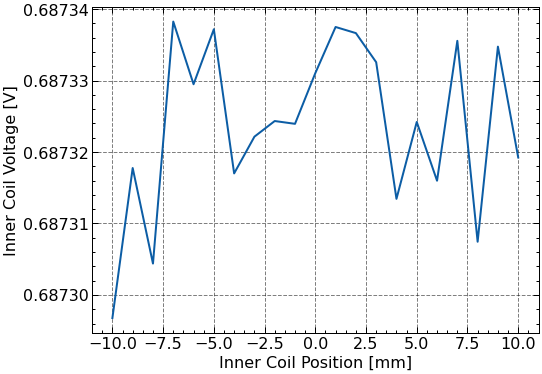

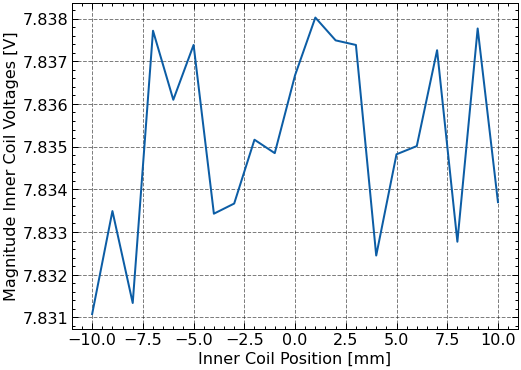

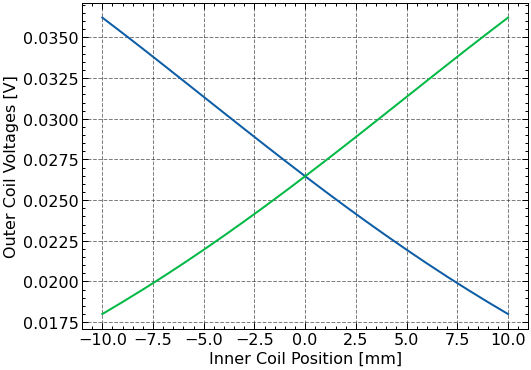

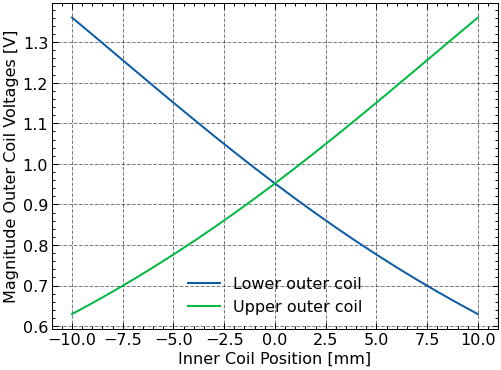

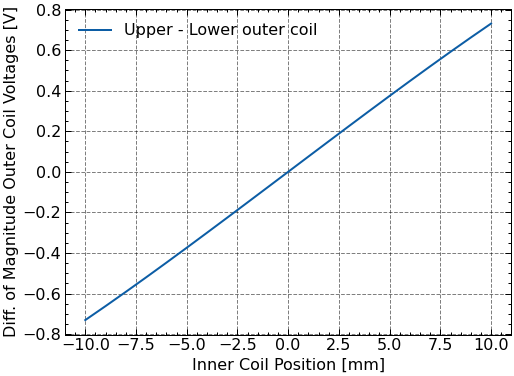

[1.48291797 1.48294242 1.48291991 1.48298727 1.48297022 1.48298367
 1.48294183 1.48294384 1.48296037 1.48295688 1.48297647 1.48299083
 1.48298494 1.48298425 1.48293125 1.48295655 1.48295976 1.48298249
 1.48293567 1.48298831 1.48294458]
[1.54417082 1.5440483  1.54392346 1.54380061 1.54367584 1.54355334
 1.54343126 1.54331274 1.54319877 1.54308772 1.54298165 1.54288078
 1.54278401 1.54269287 1.54260573 1.54252771 1.54245463 1.54238791
 1.54232506 1.54227114 1.54221931]
[1.54221759 1.54226794 1.54232318 1.54238737 1.54245385 1.54252833
 1.54260543 1.54269031 1.5427827  1.54287894 1.54298158 1.54308879
 1.54319904 1.54331422 1.5434301  1.54355196 1.54367493 1.54380024
 1.54392275 1.54404947 1.54417085]
Phase offset: -0.06125284312332657 -0.06122627795804414


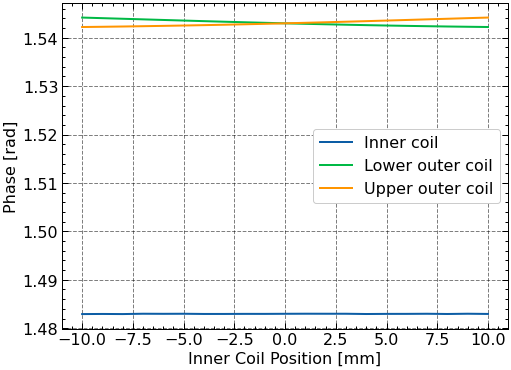

In [13]:
plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, InnCoil_Voltages.real)
plt.ylabel('Inner Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(InnCoil_Voltages))
plt.ylabel('Magnitude Inner Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Voltages.real, label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Voltages.real, label="Upper outer coil")
plt.ylabel('Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(LowOutCoil_Voltages), label="Lower outer coil")
plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages), label="Upper outer coil")
plt.ylabel('Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages), label="Upper - Lower outer coil")
plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

InnCoil_Phases = np.angle(InnCoil_Voltages)
LowOutCoil_Phases = np.angle(LowOutCoil_Voltages)
UppOutCoil_Phases = np.angle(UppOutCoil_Voltages)
print(InnCoil_Phases)
print(LowOutCoil_Phases)
print(UppOutCoil_Phases)
print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

plt.plot(InnCoil_Positions, InnCoil_Phases, label="Inner coil")
plt.plot(InnCoil_Positions, LowOutCoil_Phases, label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Phases, label="Upper outer coil")
plt.ylabel('Phase [rad]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

Create normalised response of the difference in the outer coils in V/mmA with magnitude of complex numbers and fit to check linearity and get sensitivity.

Fitted slope of the function: 3.6946422454440984


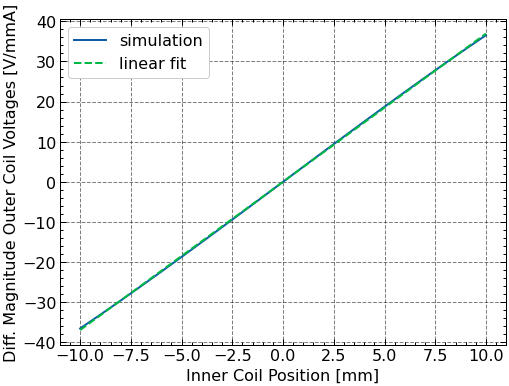

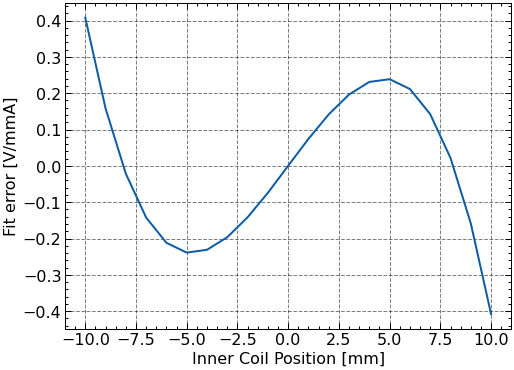

[-3.69466401e+01 -3.32519979e+01 -2.95573556e+01 -2.58627134e+01
 -2.21680711e+01 -1.84734289e+01 -1.47787866e+01 -1.10841444e+01
 -7.38950216e+00 -3.69485991e+00 -2.17666144e-04  3.69442458e+00
  7.38906682e+00  1.10837091e+01  1.47783513e+01  1.84729936e+01
  2.21676358e+01  2.58622781e+01  2.95569203e+01  3.32515625e+01
  3.69462048e+01]
[-3.65383914e+01 -3.30939084e+01 -2.95791046e+01 -2.60050964e+01
 -2.23799483e+01 -1.87122629e+01 -1.50098735e+01 -1.12804707e+01
 -7.53105081e+00 -3.76908382e+00  5.19524497e-05  3.76874562e+00
  7.53084891e+00  1.12800998e+01  1.50094305e+01  1.87115482e+01
  2.23791879e+01  2.60046022e+01  2.95788052e+01  3.30931541e+01
  3.65381455e+01]


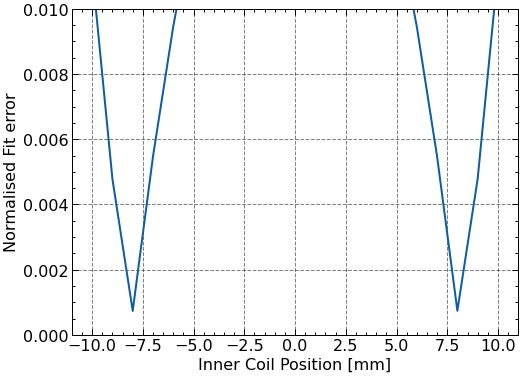

In [14]:
Norm_OutCoil_Signals = (abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages))/StepSize/InnCoil_Current

def linfunc(x, a, b):
     return a*x + b

optimizedParameters, pcov = opt.curve_fit(linfunc, InnCoil_Positions, Norm_OutCoil_Signals);
print("Fitted slope of the function:",optimizedParameters[0])
fitted_Norm_OutCoil_Signals = linfunc(InnCoil_Positions, *optimizedParameters)

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)
plt.ylabel('Fit error [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

print(fitted_Norm_OutCoil_Signals)
print(Norm_OutCoil_Signals)

plt.plot(InnCoil_Positions, abs(Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)/abs(Norm_OutCoil_Signals))
plt.ylabel('Normalised Fit error')
plt.xlabel('Inner Coil Position [mm]')
plt.ylim(0.0,0.01)
plt.show()

#### Close FEMM
When the analysis is completed, FEMM can be shut down. Comment out when you want the FEMM window to remain open after simulation to do visual checks.

In [15]:
femm.closefemm()